<table>
<tr style="border:none;">
<td style="border:none;"><a href="https://fra.utn.edu.ar/">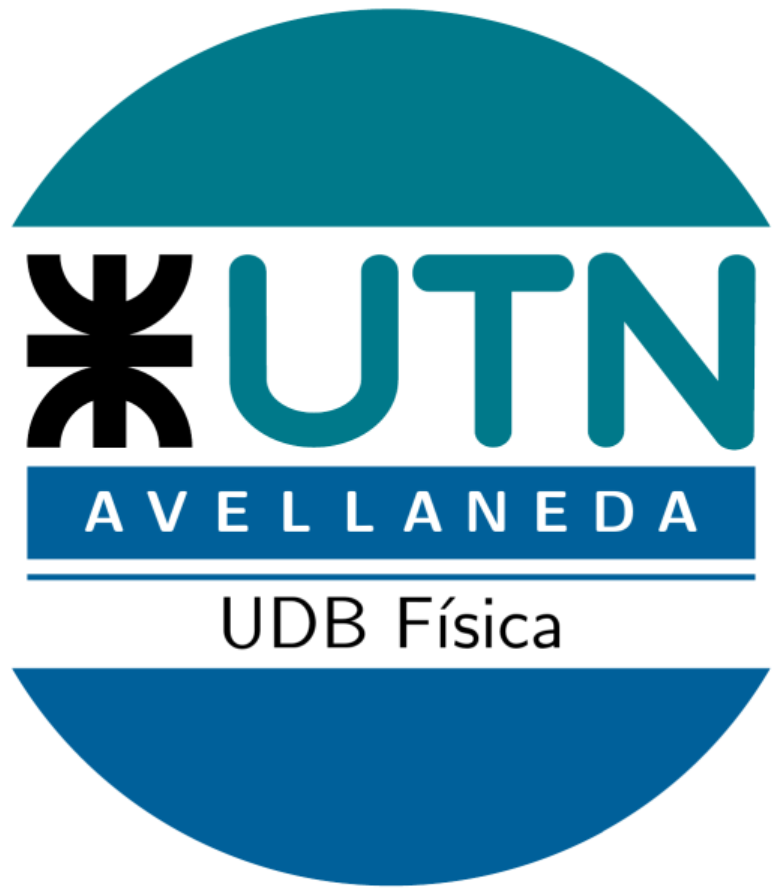</a></td><td style="border:none;"><font face="times" size=4>Física 2<br>2025<br>Electromagnetismo<br>Material de referencia</font></td></tr>
</table> 

</br>

<table>
<tr style="border:none;">
<td style="border:none;"><a href="https://creativecommons.org/licenses/by-nc-sa/4.0/deed.es">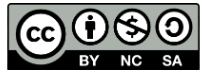</a></td><td style="border:none;"><font face="times" size=4>2025 Edgardo Palazzo (epalazzo@fra.utn.edu.ar)</font></td></tr>
</table>

# Método de momentos

---

Libro dedicado al método de momentos, gibson.

Libro con más métodos numéricos, pero con una muy buena explicación del método de momentos más sencillo Sadiku.

Otras geometrías para el mesh, Dworsky. Modeling 3d geometries: Gibson.

In [9]:
import matplotlib.pyplot as plt
import pylab as py
import numpy as np
from scipy import integrate
from numpy import sqrt, cos, sin, pi
import sys

# py.rcParams['mathtext.fontset'] = 'stix'
# py.rcParams.update({'font.size': 14})


np.seterr(divide='ignore')  # Elimina advertencia al dividir por cero.
# %precision %.3f

!pip install --index-url https://test.pypi.org/simple/ --no-deps --upgrade frautnEM
from frautnEM.puntuales import plotEf, equipotencialesPuntuales, V

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  !pip --quiet install ipympl
  from google.colab import output
  output.enable_custom_widget_manager()

# Figuras interactivas.
# Comentar si se quiere mantener las figuras luego de cerrar el cuaderno.
# %matplotlib widget

Looking in indexes: https://test.pypi.org/simple/


## Cilindro conductor

Falta:  
- Verificar sum V = 1 V
- Realizar gráficos de carga y V.
- ¿Ubicar las cargas en la superficie?
- discretización de tamaño variable

Se sigue el método descripto en el capítulo 2 del libro _The method of moments in electromagnetics_, W. C. Gibson.

<div><image src="img/c2_cilindro.png"  width="400"></div>

<div><image src="img/c2_cilindro_discretizado.png"  width="500"></div>


La ecuación 2.12 no es correcta, debería ser:

$$
Z_{mn} = \int_{(n-1)\Delta}^{n\Delta} \frac{1}{\sqrt{(x_m - x')^2+a^2}} dx' \, .
$$

La ecuación 2.14 no es el resultado correcto, sino el siguiente:

$$
Z_{mn} = \log \left ( \frac{\sqrt{a^2+(x_a-x_m)^2}-(x_a-x_m)}{\sqrt{a^2+(x_b-x_m)^2}-(x_b-x_m)} \right ) \, ,
$$

siendo $x_a = (n-1)\Delta$ y $x_b =n\Delta$. 

In [37]:
def Zmn(row, m, a, delta):
    xm = delta/2 + (m-1) * delta  # El centro del segmento.
    xa = (row - 1) * delta
    xb = row * delta
    num = np.sqrt(a**2 + (xb - xm)**2) + (xb - xm)
    den = np.sqrt(a**2 + (xa - xm)**2) + (xa - xm)
    
    return np.log(num/den)

In [39]:
# Potencial:
b = 1
# Largo:
L = 1

N = 100
a = 0.01
delta = L/N

row = np.array(np.arange(1,N+1))
Z = np.array([]).reshape(0,N)
for m in np.arange(1,N+1):
    Z = np.concatenate([Z, Zmn(row, m, a, delta).reshape(1,N)], axis=0)

B = np.ones(N)*b
q = np.linalg.solve(Z, B)

# Check that the solution is correct:
np.allclose(np.dot(Z, q), B)

True

In [40]:
# El resultado es k*sigma, entonces:
q = q * delta / 9E9

# Se arma la lista de cargas del hilo:
x = (-L/2 + delta * (-0.5 + row)).reshape(1,N)
y = np.zeros(N).reshape(1,N)
z = np.zeros(N).reshape(1,N)
Q = np.concatenate([q.reshape(1,N),x,y,z], axis=0)
Q = np.transpose(Q)


In [41]:
Nx = 200
Ny = 200
x = np.linspace(-1,1,Nx)        # x variables in 1D
y = np.linspace(-1,1,Ny)        # y variable in 1D
X,Y = np.meshgrid(x,y)          # 2D meshgrid


In [42]:
def Efield2D(x, y, Q):
    """Calcula las componentes del campo eléctrico en N/C.
    Ingresar valores de x,y,z en metros y q en coulomb.
    Q es una lista de la forma:
    Q = [
        [q1,x1,y1],
        [q2,x2,y2],
        ...
        [qN,xN,yN]
    ]
    """
    k = 9E9   #Constante de Coulomb en las unidades correspondientes.

    Ei,Ej= 0,0
    for qi in Q:
        r = ((x - qi[1])**2 + (y - qi[2])**2)**(3/2)
        Ei = Ei + k * qi[0] * (x - qi[1]) / r
        Ej = Ej + k * qi[0] * (y - qi[2]) / r

    return Ei, Ej

def region_conductor(x,y):
    regionx = np.piecewise(X, [(X > -0.5) & (X < 0.5), ], [0, 1])
    regiony = np.piecewise(Y, [(Y > -0.01) & (Y < 0.01), ], [0, 1])
    region = regionx + regiony
    region = np.piecewise(region, [region > 0], [1, 0])

    return region

# Defining custom plotting functions
def my_contourf(x,y,F,ttl,clrmp = 'inferno'):
    cnt = py.contourf(x,y,F,41,cmap = clrmp)
    
    # Antialiasing block for exporting figure to pdf later
    for c in cnt.collections:
        c.set_edgecolor("face")
    
    cbar = py.colorbar()
    # py.xlabel(r'$x$',fontsize=26); py.ylabel(r'$y$',fontsize=26); 
    py.xlabel(r'$x$'); py.ylabel(r'$y$'); 
    # py.title(ttl)
    # cbar.set_label(ttl,fontsize=26)
    cbar.set_label(ttl)
    # py.xlim([x[0],x[-1]])
    # py.ylim([y[0],y[-1]])
    return 0


/tmp/ipykernel_4568/1614861169.py:35: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c in cnt.collections:


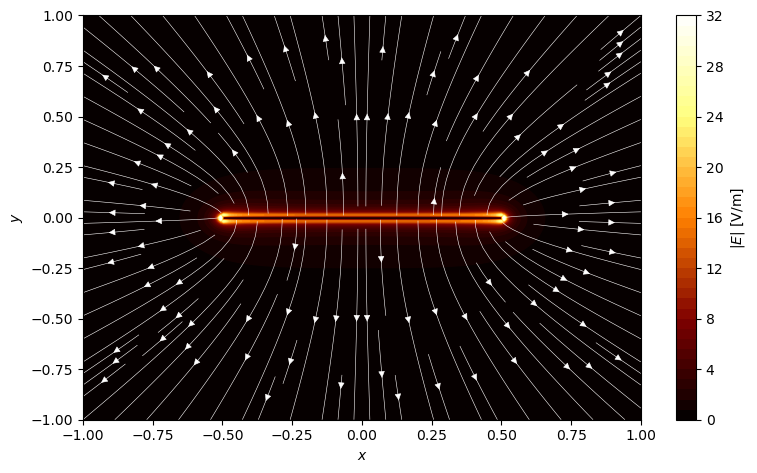

In [43]:
region = region_conductor(X,Y)
Ei, Ej = Efield2D(X,Y,Q)

Ei = Ei * region 
Ej = Ej * region 

Emod = np.sqrt(Ei**2 + Ej**2)

# py.figure(figsize = (12,7))
py.figure(figsize = (9,5.25))
my_contourf(X,Y,Emod,r'$|E|$ [V/m]','afmhot')
py.streamplot(X,Y,Ei,Ej,color = 'w',density = 1.2, linewidth = 0.4)


In [ ]:
# Carga totoal:
np.sum(q)

In [ ]:
# Test: valor de V en los puntos campo. Falta hacer un gráfico.
V(0,a,0,Q)

0.9996157965482547

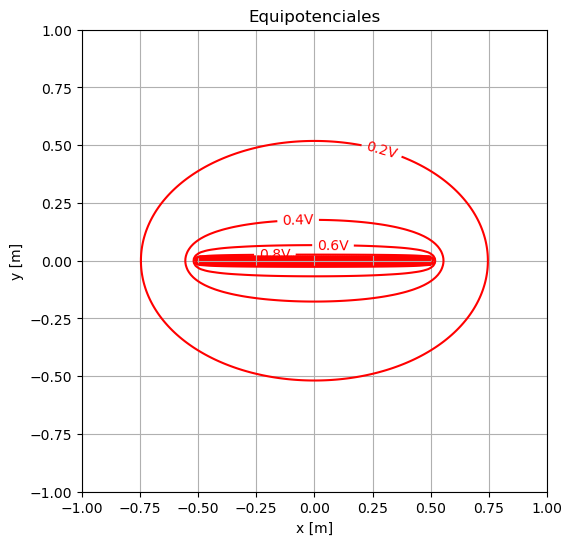

In [47]:
# Se eligen cuáles equipotenciales mostrar en una lista. 
niveles = [0.2, 0.4, 0.6, 0.8]

equipotencialesPuntuales(Q, niveles=niveles)

## Placa conductora

<div><image src="img/c2_thin_plate.png"  width="500"></div>

Self terms: (falta revisar esta cuenta)

<div><image src="img/c2_self_terms.png"  width="500"></div>


In [ ]:
def Zmn(row, m, n, a, delta):
    if m == n:
        out = 2*a



    xm = delta/2 + (m-1) * delta  # El centro del segmento.
    xa = (row - 1) * delta
    xb = row * delta
    num = np.sqrt(a * a + (xa - xm) * (xa - xm)) - (xa - xm)
    den = np.sqrt(a * a + (xb - xm) * (xb - xm)) - (xb - xm)
    
    return np.log(num/den)

In [3]:
for a in np.arange(3):
    f = lambda y, x: x*(y+a)**2
    print(integrate.dblquad(f, 0, 2, 0, 1))

(0.6666666666666667, 7.401486830834377e-15)
(4.666666666666667, 5.181040781584064e-14)
(12.666666666666668, 1.4062824978585317e-13)


In [5]:
b = np.array([0,1,2])
f = lambda y, x, b: x*(y+b)**2
print(integrate.dblquad(f, 0, 2, 0, 1))

TypeError: only length-1 arrays can be converted to Python scalars

## Referencias

<a id='sadiku'>[1]</a> Sadiku, M.N.O. (2018). $\emph{Computational Electromagnetics with MATLAB}$, (4ta ed.). CRC Press. https://doi.org/10.1201/9781315151250  
<a id='gibson'>[2]</a> Gibson, W.C. (2021). $\emph{The Method of Moments in Electromagnetics}$, (3ra ed.). Chapman and Hall/CRC. https://doi.org/10.1201/9780429355509  
<a id='dworsky'>[2]</a> Dworsky, L. N. (2014). $\emph{Introduction to Numerical Electrostatics Using MATLAB}$. Wiley. https://doi.org/10.1002/9781118758571


<!-- pp. 123-157 -->
